In [ ]:
## Claude try one

In [24]:
# Imports and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           f1_score, precision_score, recall_score,mean_squared_error)


import xgboost as xgb
from xgboost import XGBClassifier

# import warnings
# warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# For Jupyter notebook - ensure plots display inline
%matplotlib inline


In [19]:

#Prepare data for modeling + functions

class ChessWinnerPredictor:
    def __init__(self, csv_file_path):
        """Initialize the chess winner predictor"""
        self.csv_file_path = csv_file_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.selected_features = None
        self.feature_scores = None
        self.le = LabelEncoder()
        
    def load_and_prepare_data(self):
        """Load CSV file and prepare data for modeling"""
        print("Loading data...")
        self.df = pd.read_csv(self.csv_file_path)
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print(f"\nTarget distribution:")
        print(self.df['winner'].value_counts())
        
        # Handle missing values
        print(f"\nMissing values per column:")
        missing_values = self.df.isnull().sum()
        print(missing_values[missing_values > 0])
        
        # Prepare features (exclude id and winner columns)
        feature_columns = [col for col in self.df.columns if col not in ['id', 'winner']]
        self.X = self.df[feature_columns].copy()
        
        # Handle categorical variables if any
        for col in self.X.columns:
            if self.X[col].dtype == 'object':
                self.X[col] = LabelEncoder().fit_transform(self.X[col].astype(str))
        
        # Fill missing values with median for numeric columns
        self.X = self.X.fillna(self.X.median())
        
        # Encode target variable
        self.y = self.le.fit_transform(self.df['winner'])
        
        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Target classes: {dict(zip(self.le.classes_, range(len(self.le.classes_))))}")
        
    def feature_selection(self, methods=['univariate', 'rfe', 'model_based'], k_best=20):
        """Perform feature selection using multiple methods"""
        print(f"\n=== FEATURE SELECTION ===")
        
        # Split data first
        X_temp, _, y_temp, _ = train_test_split(self.X, self.y, test_size=0.2, 
                                                random_state=42, stratify=self.y)
        
        selected_features_dict = {}
        
        # 1. Univariate Feature Selection
        if 'univariate' in methods:
            print("1. Univariate Feature Selection (f_classif)...")
            selector_univariate = SelectKBest(score_func=f_classif, k=min(k_best, self.X.shape[1]))
            X_selected = selector_univariate.fit_transform(X_temp, y_temp)
            
            feature_scores = pd.DataFrame({
                'feature': self.X.columns,
                'score': selector_univariate.scores_,
                'p_value': selector_univariate.pvalues_
            }).sort_values('score', ascending=False)
            
            selected_features_dict['univariate'] = feature_scores.head(k_best)['feature'].tolist()
            print(f"Top 10 features by univariate selection:")
            print(feature_scores.head(10)[['feature', 'score']])
        
        # 2. Recursive Feature Elimination
        if 'rfe' in methods:
            print(f"\n2. Recursive Feature Elimination...")
            estimator = XGBClassifier(random_state=42, eval_metric='logloss')
            rfe = RFE(estimator=estimator, n_features_to_select=min(k_best, self.X.shape[1]))
            rfe.fit(X_temp, y_temp)
            
            selected_features_dict['rfe'] = self.X.columns[rfe.support_].tolist()
            print(f"Selected {sum(rfe.support_)} features with RFE")
        
        # 3. Model-based Feature Selection
        if 'model_based' in methods:
            print(f"\n3. Model-based Feature Selection...")
            estimator = XGBClassifier(random_state=42, eval_metric='logloss')
            estimator.fit(X_temp, y_temp)
            
            selector_model = SelectFromModel(estimator, prefit=True, max_features=k_best)
            selected_features_dict['model_based'] = self.X.columns[selector_model.get_support()].tolist()
            print(f"Selected {sum(selector_model.get_support())} features with model-based selection")
        
        # Combine features from all methods
        all_selected = set()
        for method, features in selected_features_dict.items():
            all_selected.update(features)
        
        self.selected_features = list(all_selected)
        print(f"\nTotal unique features selected: {len(self.selected_features)}")
        
        # Store feature importance for later visualization
        if 'model_based' in methods:
            self.feature_scores = pd.DataFrame({
                'feature': self.X.columns,
                'importance': estimator.feature_importances_
            }).sort_values('importance', ascending=False)
        
        return selected_features_dict
    
    def train_model(self, use_feature_selection=True, perform_grid_search=True):
        """Train XGBoost model with hyperparameter tuning"""
        print(f"\n=== MODEL TRAINING ===")
        
        # Use selected features or all features
        if use_feature_selection and self.selected_features:
            X_final = self.X[self.selected_features]
            print(f"Using {len(self.selected_features)} selected features")
        else:
            X_final = self.X
            print(f"Using all {X_final.shape[1]} features")
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_final, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")
        
        if perform_grid_search:
            print("Performing hyperparameter tuning...")
            
            # Define parameter grid
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
            
            # Grid search
            xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
            grid_search = GridSearchCV(
                estimator=xgb_model,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
                n_jobs=-1,
                verbose=1
            )
            
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
            
        else:
            # Train with default parameters
            self.model = XGBClassifier(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss'
            )
            self.model.fit(self.X_train, self.y_train)
            
        print("Model training completed!")
    
    def evaluate_model(self):
        """Comprehensive model evaluation"""
        print(f"\n=== MODEL EVALUATION ===")
        
        # Predictions
        y_pred = self.model.predict(self.X_test)
        y_pred_train = self.model.predict(self.X_train)
        y_pred_proba = self.model.predict_proba(self.X_test)
        
        # Basic metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc_score = roc_auc_score(self.y_test, y_pred_proba[:, 1])
        MSE_train = mean_squared_error(self.y_train,y_pred_train)
        MSE_test = mean_squared_error(self.y_test,y_pred)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_score:.4f}")
        print(f"MSE_train: {MSE_train:.4f}")
        print(f"MSE_test: {MSE_test:.4f}")
        
        # Classification report
        print(f"\nClassification Report:")
        target_names = self.le.classes_
        print(classification_report(self.y_test, y_pred, target_names=target_names))
        
        # Cross-validation scores
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='accuracy')
        print(f"\nCross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_score': auc_score,
            'MSE_train': MSE_train,
            'MSE_test': MSE_test,
            'cv_scores': cv_scores
        }
    
    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print(f"\n=== CREATING VISUALIZATIONS ===")
        
        # Predictions for plots
        y_pred = self.model.predict(self.X_test)
        y_pred_proba = self.model.predict_proba(self.X_test)
        
        # Create subplot layout
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Confusion Matrix
        plt.subplot(2, 3, 1)
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        # 2. ROC Curve
        plt.subplot(2, 3, 2)
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba[:, 1])
        auc_score = roc_auc_score(self.y_test, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        
        # 3. Precision-Recall Curve
        plt.subplot(2, 3, 3)
        precision_vals, recall_vals, _ = precision_recall_curve(self.y_test, y_pred_proba[:, 1])
        plt.plot(recall_vals, precision_vals)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        
        # 4. Feature Importance (Top 15)
        plt.subplot(2, 3, 4)
        if hasattr(self.model, 'feature_importances_'):
            if hasattr(self, 'selected_features') and self.selected_features:
                feature_names = self.selected_features
            else:
                feature_names = self.X.columns
                
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=True).tail(15)
            
            plt.barh(range(len(importance_df)), importance_df['importance'])
            plt.yticks(range(len(importance_df)), importance_df['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importances')
        
        # 5. Prediction Probability Distribution
        plt.subplot(2, 3, 5)
        plt.hist(y_pred_proba[:, 1], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Predicted Probability (White Win)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Probabilities')
        plt.grid(True)
        
        # 6. Learning Curve (if we have training history)
        plt.subplot(2, 3, 6)
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        plt.bar(range(1, 6), cv_scores)
        plt.xlabel('CV Fold')
        plt.ylabel('Accuracy')
        plt.title('Cross-Validation Scores')
        plt.ylim([min(cv_scores)-0.01, max(cv_scores)+0.01])
        
        for i, score in enumerate(cv_scores):
            plt.text(i+1, score+0.001, f'{score:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Feature importance comparison (if feature selection was used)
        if hasattr(self, 'feature_scores') and self.feature_scores is not None:
            plt.figure(figsize=(12, 8))
            top_features = self.feature_scores.head(20)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Features by Importance (XGBoost)')
            plt.tight_layout()
            plt.show()
            
        # Return plots for Jupyter display
        return fig
    
    def run_complete_analysis(self, csv_file_path=None):
        """Run the complete analysis pipeline"""
        if csv_file_path:
            self.csv_file_path = csv_file_path
            
        print("Starting Chess Winner Prediction Analysis...")
        print("="*50)
        
        # Step 1: Load and prepare data
        self.load_and_prepare_data()
        
        # Step 2: Feature selection
        feature_selection_results = self.feature_selection()
        
        # Step 3: Train model
        self.train_model(use_feature_selection=True, perform_grid_search=True)
        
        # Step 4: Evaluate model
        evaluation_metrics = self.evaluate_model()
        
        # Step 5: Create visualizations
        self.create_visualizations()
        
        print("\n" + "="*50)
        print("Analysis completed successfully!")
        
        return evaluation_metrics

# Usage example for Jupyter Notebook:
"""
if __name__ == "__main__":
    # In Jupyter, you can run this cell by cell or all at once
    
    # Step 1: Initialize the predictor
    predictor = ChessWinnerPredictor("your_chess_data.csv")  # Replace with your CSV file path
    
    # Step 2: Run complete analysis
    results = predictor.run_complete_analysis()
    
    # Step 3: Print final summary
    print(f"\n=== FINAL SUMMARY ===")
    print(f"Model Accuracy: {results['accuracy']:.4f}")
    print(f"AUC Score: {results['auc_score']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
"""

# Alternative: Run step by step in Jupyter cells
"""
# Cell 1: Initialize and load data
predictor = ChessWinnerPredictor("your_chess_data.csv")
predictor.load_and_prepare_data()

# Cell 2: Feature selection
feature_results = predictor.feature_selection()

# Cell 3: Train model
predictor.train_model(use_feature_selection=True, perform_grid_search=True)

# Cell 4: Evaluate model
evaluation_metrics = predictor.evaluate_model()

# Cell 5: Create visualizations
plots = predictor.create_visualizations()
"""

'\n# Cell 1: Initialize and load data\npredictor = ChessWinnerPredictor("your_chess_data.csv")\npredictor.load_and_prepare_data()\n\n# Cell 2: Feature selection\nfeature_results = predictor.feature_selection()\n\n# Cell 3: Train model\npredictor.train_model(use_feature_selection=True, perform_grid_search=True)\n\n# Cell 4: Evaluate model\nevaluation_metrics = predictor.evaluate_model()\n\n# Cell 5: Create visualizations\nplots = predictor.create_visualizations()\n'

In [20]:
# Step 1: Initialize and load data
predictor = ChessWinnerPredictor("final_chess_munged_db.csv")
predictor.load_and_prepare_data()

Loading data...
Dataset shape: (12214, 25)
Columns: ['id', 'winner', 'base_time', 'game_class', 'opening_class', 'opening_eco', 'rating_dif', 'same_elo_band_flag', 'same_elo_step_flag', 'white_elo_band', 'white_castle_turn_limited', 'white_castle_before_ten', 'white_castle_before_fifteen', 'white_checks_limited_count', 'white_checks_before_fifteen', 'black_elo_band', 'black_castle_turn_limited', 'black_castle_before_ten', 'black_castle_before_fifteen', 'black_checks_before_fifteen', 'black_checks_limited_count', 'player_as_white_fav_opening_class', 'player_as_white_fav_opening_eco', 'player_white_total_games_count', 'player_black_total_games_count']

Target distribution:
winner
white    6244
black    5970
Name: count, dtype: int64

Missing values per column:
white_castle_turn_limited    1324
black_castle_turn_limited    1321
dtype: int64
Feature matrix shape: (12214, 23)
Target classes: {'black': 0, 'white': 1}


In [32]:
# Step 2: Feature selection
### features methods ['univariate', 'rfe', 'model_based']

feature_results = predictor.feature_selection(methods= 'rfe', k_best=10)


=== FEATURE SELECTION ===

2. Recursive Feature Elimination...
Selected 10 features with RFE

Total unique features selected: 10


In [33]:
# Step 3: Train the model
## use_feature_selection = FALSE uses all features instead of the ones selected in step 2

predictor.train_model(use_feature_selection=True, perform_grid_search=True)



=== MODEL TRAINING ===
Using 10 selected features
Training set size: (9771, 10)
Test set size: (2443, 10)
Performing hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.6422
Model training completed!


In [34]:
# Step 4: Evaluate the model

evaluation_metrics = predictor.evaluate_model()



=== MODEL EVALUATION ===
Accuracy: 0.6402
Precision: 0.6385
Recall: 0.6829
F1-Score: 0.6600
AUC-ROC: 0.7058
MSE_train: 0.3371
MSE_test: 0.3598

Classification Report:
              precision    recall  f1-score   support

       black       0.64      0.60      0.62      1194
       white       0.64      0.68      0.66      1249

    accuracy                           0.64      2443
   macro avg       0.64      0.64      0.64      2443
weighted avg       0.64      0.64      0.64      2443


Cross-validation Accuracy: 0.6422 (+/- 0.0413)



=== CREATING VISUALIZATIONS ===


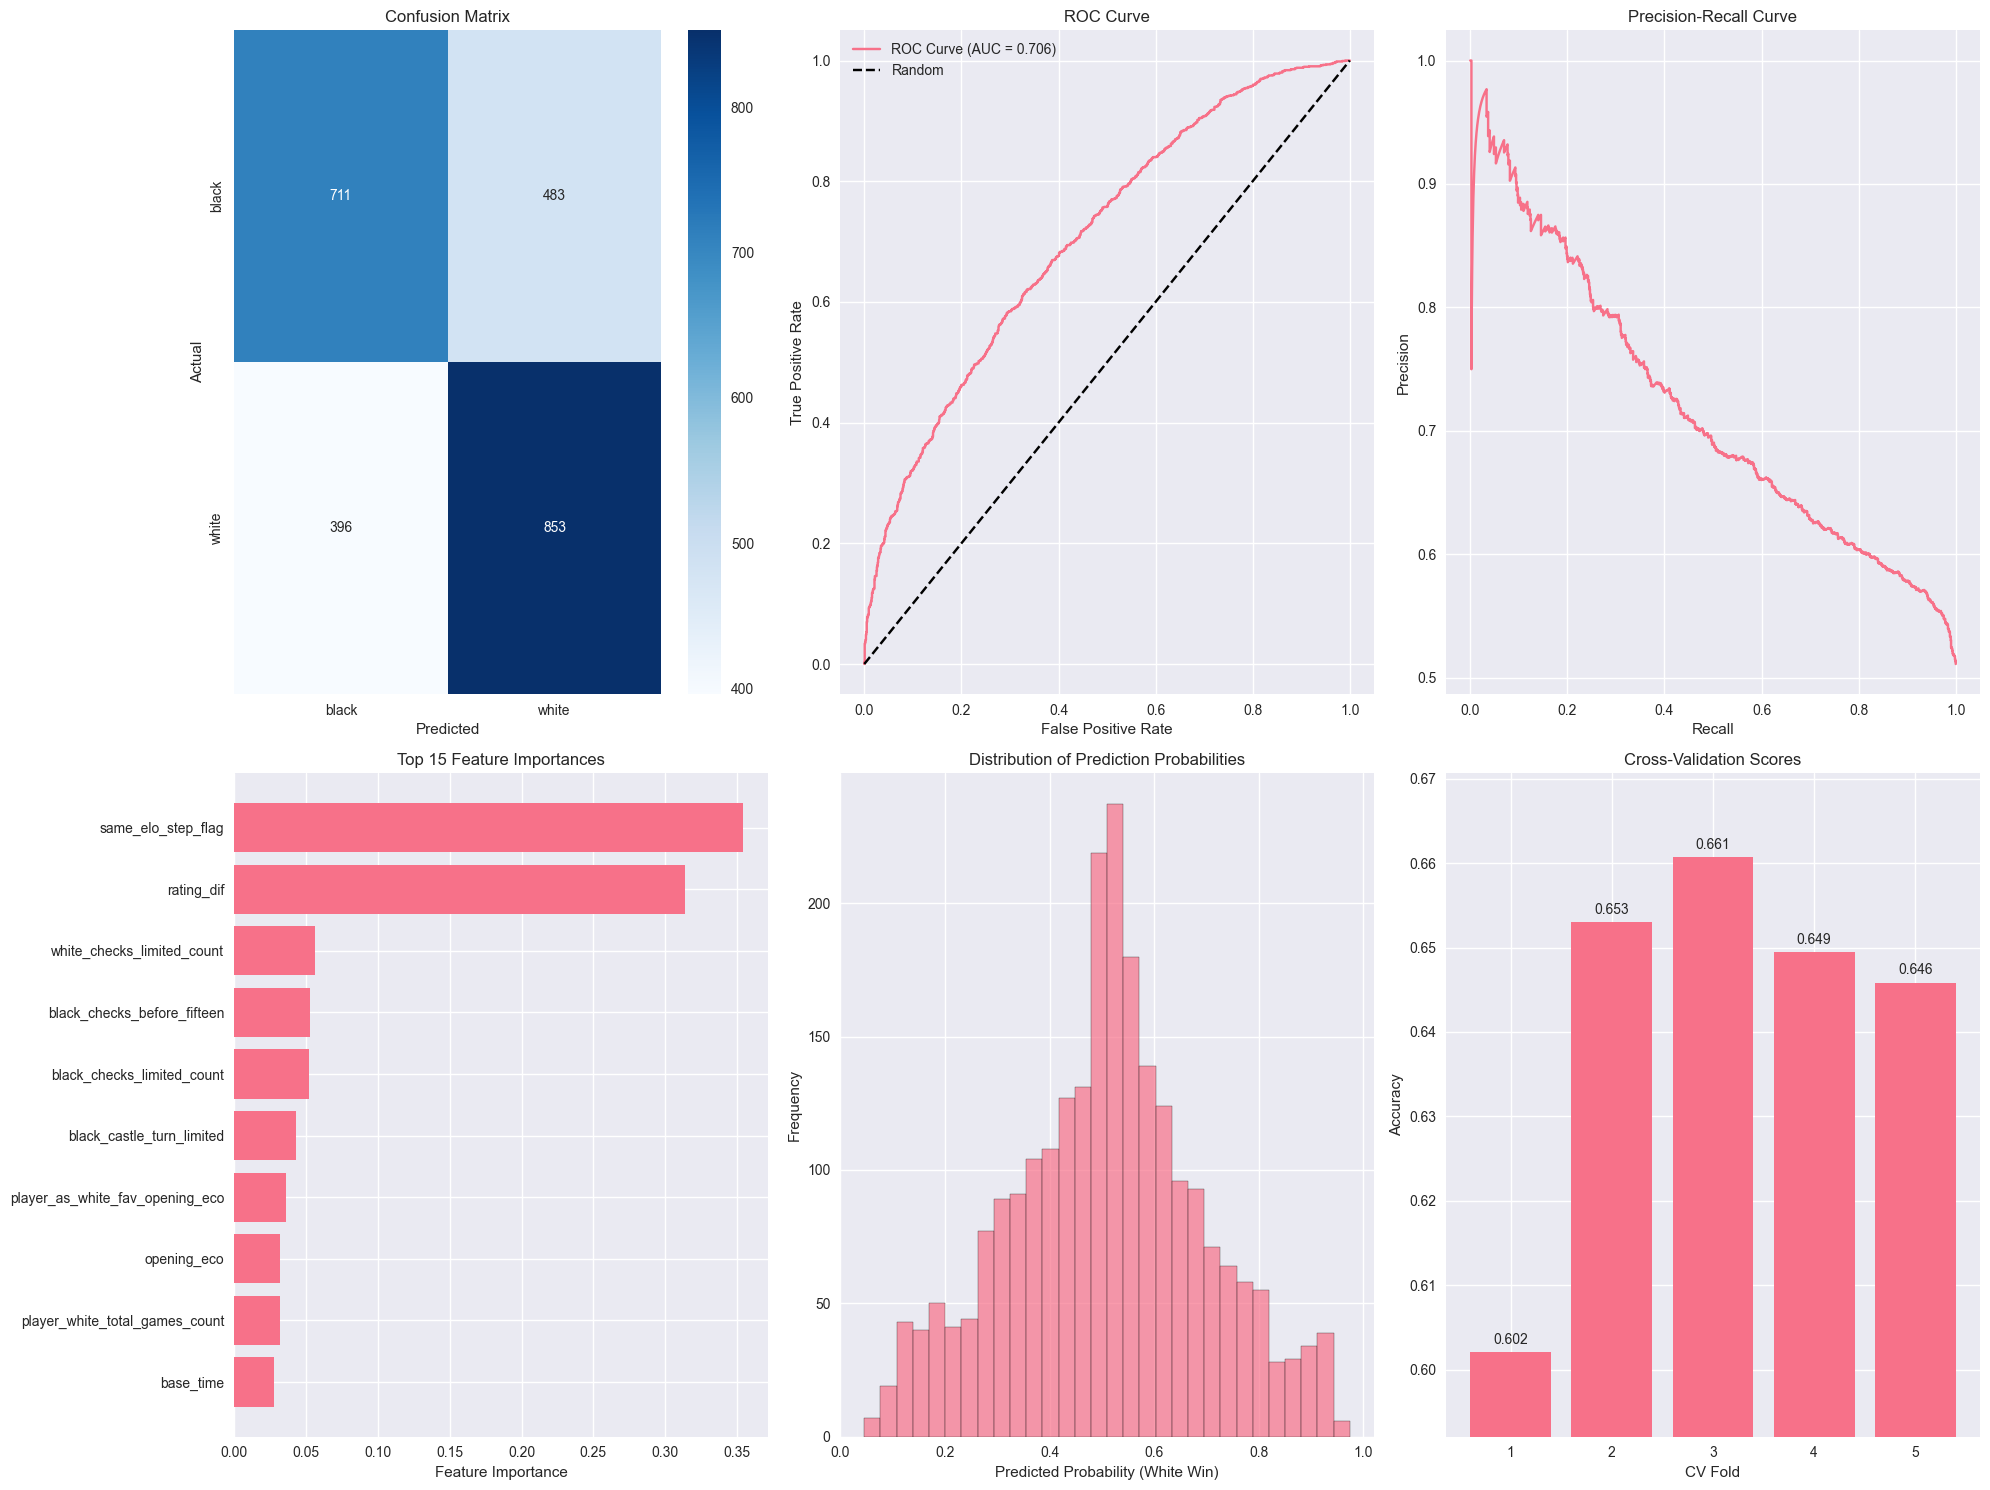

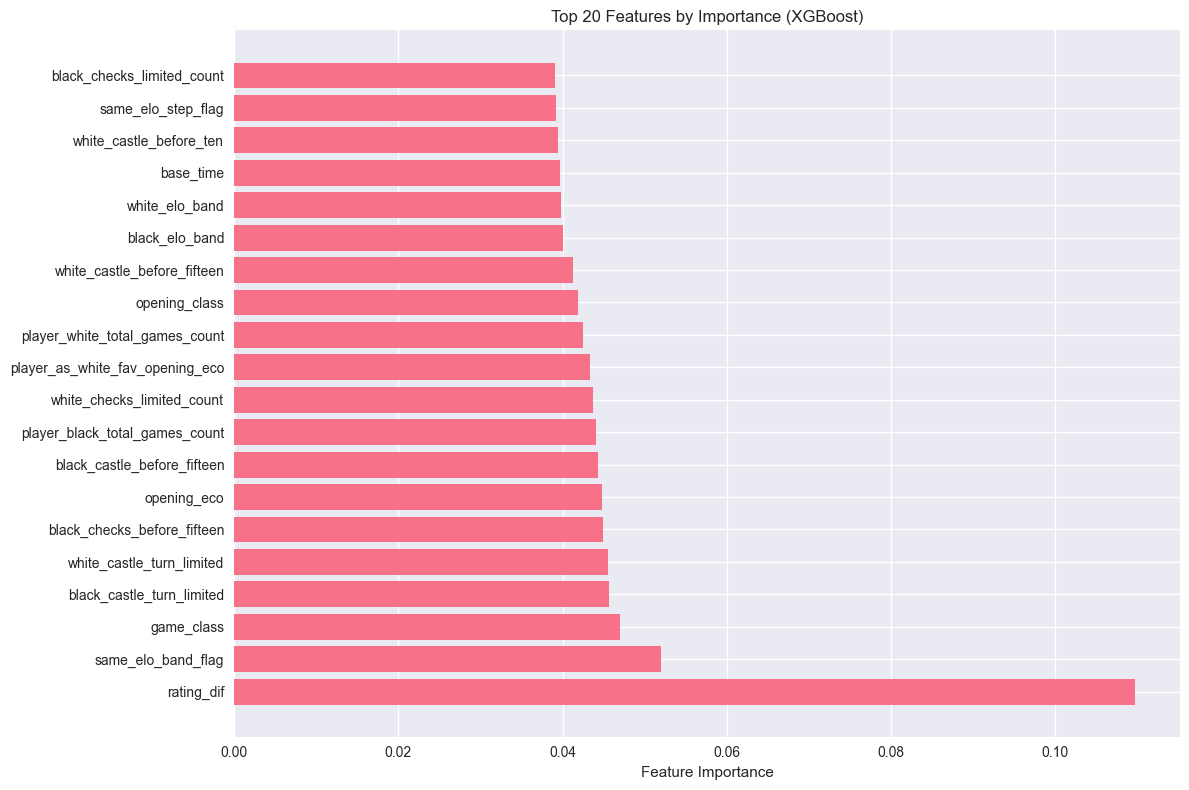

In [35]:
# Step 5: Create visualizations

plots = predictor.create_visualizations()